# Medyczne zastosowania uczenia maszynowego - zadanie 2

# Temat: Selekcja istotnych cech

Analiza zbiorów danych dotyczących raka prostaty, zawierających próbki moczu, surowicy i tkanek

Katarzyna Pieczonka, nr indeksu 132785 <br/>
Informatyka II stopień, semestr zimowy <br/>
rok akademicki 2024/25

1. Wczytanie bibliotek i zbiorów danych

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

#Odczytanie zbiorów danych
datasetM = pd.read_csv('FTIR_800-1800_mocz_1chory_0zdrowy.csv', delimiter=';', dtype=float, decimal=',') #Dane rozdzielone są średnikami
datasetS = pd.read_csv('FTIR_800-1800_surowica_1chory_0zdrowy.csv', delimiter=';', dtype=float, decimal=',')
datasetT = pd.read_csv('FTIR_800-1800_tkanka_1chory_0zdrowy.csv', delimiter=';', dtype=float, decimal=',')

noColumn1 = datasetM.shape[1]
noColumn2 = datasetS.shape[1]
noColumn3 = datasetT.shape[1]

print(f"Dataset1 - próbki moczu: \n\n {datasetM.describe()}")
print(f"Dataset2 - próbki surowicy: \n\n {datasetS.describe()}")
print(f"Dataset3 - próbki tkanek: \n\n {datasetT.describe()}")

Dataset1 - próbki moczu: 

         800.31372   800.79584   801.27796   801.76007   802.24219   802.72431  \
count  278.000000  278.000000  278.000000  278.000000  278.000000  278.000000   
mean     0.068217    0.066318    0.064601    0.063017    0.061487    0.059932   
std      0.036988    0.036715    0.036447    0.036185    0.035931    0.035692   
min      0.004100    0.003960    0.003980    0.004140    0.004360    0.004530   
25%      0.044698    0.042825    0.041243    0.039470    0.037968    0.036495   
50%      0.056665    0.054920    0.053175    0.051505    0.049850    0.048780   
75%      0.086303    0.084047    0.081588    0.079360    0.077628    0.076035   
max      0.234840    0.232660    0.230860    0.229350    0.228010    0.226710   

        803.20642   803.68854   804.17066   804.65277  ...  1796.84919  \
count  278.000000  278.000000  278.000000  278.000000  ...  278.000000   
mean     0.058317    0.056656    0.055002    0.053406  ...    0.029420   
std      0.035474   

2. Przygotowanie zbiorów danych - sprawdzanie brakujących wartości i usuwanie duplikatów.

In [2]:
#Sprawdzanie braków danych w dataset1
print("Liczba brakujących wartości dla poszczególnych kolumn w dataset1:")
missing_values = datasetM.isnull().sum()
for col, value in missing_values.items():
    if value != 0:
        print(f"{col}, brak: {value} wartości")

#Sprawdzanie duplikatów w dataset1
duplicates = datasetM.duplicated().sum()
print(f"Duplikaty: {duplicates}")
print("Usuwanie duplikatów: ")
datasetM = datasetM.drop_duplicates() #Funkcja usuwająca duplikaty
duplicates = datasetM.duplicated().sum()
print(f"Duplikaty: {duplicates}")

#####################################################

#Sprawdzanie braków danych w dataset2
print("Liczba brakujących wartości dla poszczególnych kolumn w dataset2:")
missing_values2 = datasetS.isnull().sum()
for col, value in missing_values2.items():
    if value != 0:
        print(f"{col}, brak: {value} wartości")

#Sprawdzanie duplikatów w dataset2
duplicates2 = datasetS.duplicated().sum()
print(f"Duplikaty: {duplicates2}")
print("Usuwanie duplikatów: ")
datasetS = datasetS.drop_duplicates()
duplicates2 = datasetS.duplicated().sum()
print(f"Duplikaty: {duplicates2}")

####################################################

#Sprawdzanie braków danych w dataset3
print("Liczba brakujących wartości dla poszczególnych kolumn w dataset3:")
missing_values3 = datasetT.isnull().sum()
for col, value in missing_values3.items():
    if value != 0:
        print(f"{col}, brak: {value} wartości")

#Sprawdzanie duplikatów w dataset3
duplicates3 = datasetT.duplicated().sum()
print(f"Duplikaty: {duplicates3}")
print("Usuwanie duplikatów: ")
datasetT = datasetT.drop_duplicates()
duplicates3 = datasetT.duplicated().sum()
print(f"Duplikaty: {duplicates3}")

Liczba brakujących wartości dla poszczególnych kolumn w dataset1:
Duplikaty: 2
Usuwanie duplikatów: 
Duplikaty: 0
Liczba brakujących wartości dla poszczególnych kolumn w dataset2:
Duplikaty: 0
Usuwanie duplikatów: 
Duplikaty: 0
Liczba brakujących wartości dla poszczególnych kolumn w dataset3:
Duplikaty: 2
Usuwanie duplikatów: 
Duplikaty: 0


3. Podział na cechy i etykiety

In [3]:
X_mocz = datasetM.iloc[:, :-1].values #Część tabeli zawierająca atrybuty
y_mocz = datasetM.iloc[:, -1].values #Kolumna zawierająca etykiety chory/zdrowy

X_surowica = datasetS.iloc[:, :-1].values
y_surowica = datasetS.iloc[:, -1].values

X_tkanka = datasetT.iloc[:, :-1].values
y_tkanka = datasetT.iloc[:, -1].values   

# Zadanie:

1. Podział na zbiór treningowy i testowy (10-krotna CV)
2. W każdym podziale na zbiorze treningowym wykonujemy selekcję cech RF (10%, 25%, 50% najbardziej istotnych cech stosując MeanDecreaseAccuracy lub MeanDecreaseGini) z różną liczbą drzew: 500, 1000, 5000. Dla każdej opcji sprawdzić błąd OOB oraz importance. Generujemy wykresy importance.
 Klasyfikujemy zbiór testowy modelem zbudowanym na zbiorze treningowym i zbiorze selekcjonowanych cech. Zastosować dowolny klasyfikator, np. kNN, SVM lub C5.0
 Porównujemy wyniki dla pełnego zbioru cech i zbioru selekcjonowanego.

ad 1. Tworzenie podziału na zbiór treningowy i testowy za pomocą 10-krotnej walidacji krzyżowej

In [14]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) #n_splits oznacza na ile części zostanie podzielony cały zbiór

# Dataset1 - próbki moczu

ad 2. Selekcja cech za pomocą modelu Random Forest

Fold nr 1: błąd OOB dla 500 drzew = 0.0000
Fold nr 2: błąd OOB dla 500 drzew = 0.0000
Fold nr 3: błąd OOB dla 500 drzew = 0.0000
Fold nr 4: błąd OOB dla 500 drzew = 0.0000
Fold nr 5: błąd OOB dla 500 drzew = 0.0000
Fold nr 6: błąd OOB dla 500 drzew = 0.0000
Fold nr 7: błąd OOB dla 500 drzew = 0.0000
Fold nr 8: błąd OOB dla 500 drzew = 0.0000
Fold nr 9: błąd OOB dla 500 drzew = 0.0000
Fold nr 10: błąd OOB dla 500 drzew = 0.0000
Średni błąd OOB dla 500 drzew: 0.0000


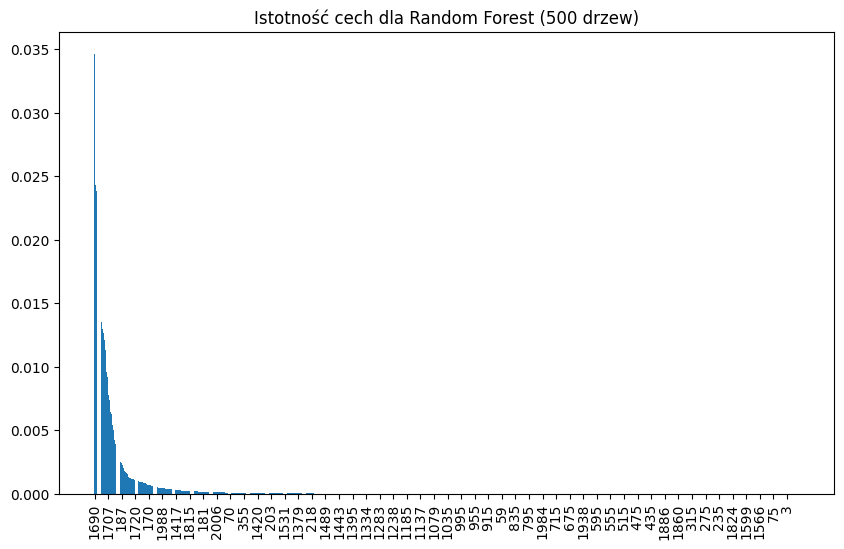

Fold nr 1: błąd OOB dla 1000 drzew = 0.0040
Fold nr 2: błąd OOB dla 1000 drzew = 0.0000
Fold nr 3: błąd OOB dla 1000 drzew = 0.0000
Fold nr 4: błąd OOB dla 1000 drzew = 0.0000
Fold nr 5: błąd OOB dla 1000 drzew = 0.0000
Fold nr 6: błąd OOB dla 1000 drzew = 0.0000
Fold nr 7: błąd OOB dla 1000 drzew = 0.0000
Fold nr 8: błąd OOB dla 1000 drzew = 0.0000
Fold nr 9: błąd OOB dla 1000 drzew = 0.0000
Fold nr 10: błąd OOB dla 1000 drzew = 0.0000
Średni błąd OOB dla 1000 drzew: 0.0004


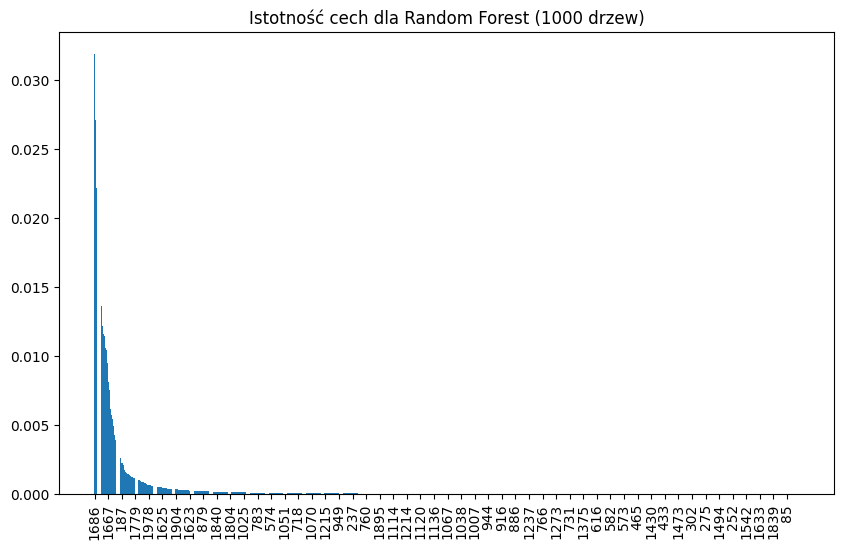

Fold nr 1: błąd OOB dla 5000 drzew = 0.0040
Fold nr 2: błąd OOB dla 5000 drzew = 0.0000
Fold nr 3: błąd OOB dla 5000 drzew = 0.0000
Fold nr 4: błąd OOB dla 5000 drzew = 0.0000
Fold nr 5: błąd OOB dla 5000 drzew = 0.0000
Fold nr 6: błąd OOB dla 5000 drzew = 0.0000
Fold nr 7: błąd OOB dla 5000 drzew = 0.0000
Fold nr 8: błąd OOB dla 5000 drzew = 0.0000
Fold nr 9: błąd OOB dla 5000 drzew = 0.0000
Fold nr 10: błąd OOB dla 5000 drzew = 0.0000
Średni błąd OOB dla 5000 drzew: 0.0004


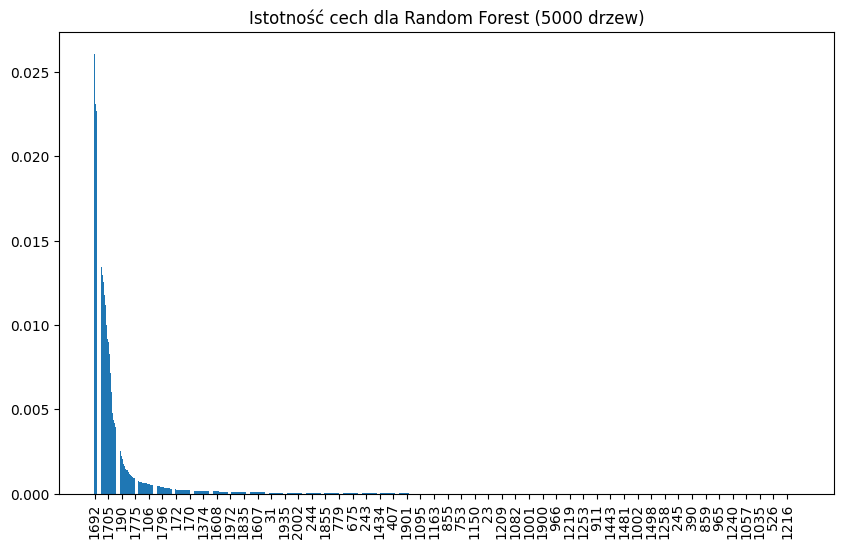

In [15]:
trees = [500, 1000, 5000] #parametry modelu, liczba drzew

for tree in trees:
    model = RandomForestClassifier(n_estimators=tree, random_state=42, oob_score=True)

    oob_errors = []
    fold = 1
    for train_idx, test_idx in cv.split(X_mocz, y_mocz):
        # Podział na zbiór treningowy i testowy dla każdego folda
        X_train, X_test = X_mocz[train_idx], X_mocz[test_idx]
        y_train, y_test = y_mocz[train_idx], y_mocz[test_idx]

        model.fit(X_train, y_train) # Treninowanie modelu Random Forest
        
        # Zbieranie błędu OOB
        oob_errors.append(1 - model.oob_score_)
        print(f"Fold nr {fold}: błąd OOB dla {tree} drzew = {1 - model.oob_score_:.4f}")
        fold += 1

    # Średni błąd OOB dla wszystkich foldów
    avg_oob_error = np.mean(oob_errors)
    print(f"Średni błąd OOB dla {tree} drzew: {avg_oob_error:.4f}")
    
    # Obliczanie istotności cech
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]

    # Generowanie wykresu istotności cech
    plt.figure(figsize=(10,6))
    plt.title(f"Istotność cech dla Random Forest ({tree} drzew)")
    plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
    plt.xticks(range(0, len(feature_importances), 40), indices[::40], rotation=90)  # Wyświetli co 40. etykietę    
    plt.show()

    

Selekcja cech  - na podstawie istotności cech wybieramy te najbardziej istotne (10%, 25%, 50%)

In [16]:
# Wybieranie procentu najbardziej istotnych cech
n_features_10 = int(0.1 * len(feature_importances))
n_features_25 = int(0.25 * len(feature_importances))
n_features_50 = int(0.5 * len(feature_importances))

# Indeksy wybranych cech
selected_features_10 = indices[:n_features_10]
selected_features_25 = indices[:n_features_25]
selected_features_50 = indices[:n_features_50]

print(f"10% najbardziej istotnych cech: {selected_features_10}")
print(f"25% najbardziej istotnych cech: {selected_features_25}")
print(f"50% najbardziej istotnych cech: {selected_features_50}")

10% najbardziej istotnych cech: [1692 1685 1683 1686 1691 1684 1687 1690 1681 1689 1688 1682 1693 1679
 1680 1675 1673 1676 1677 1678 1672 1694 1670 1666 1697 1696 1699 1674
 1665 1698 1669 1695 1668 1702 1671 1703 1701 1664 1700 1704 1705 1661
 1667 1660 1659 1662 1663 1658 1656 1707 1657 1706 1654 1655 1710  188
 1651 1652 1649 1708 1709 1653 1711  187  189 1713  185 1648 1712  184
 1650 1647  186 1646 1645 1640 1643 1644 1714 1642  190 1641  191 1635
 1638  192 1634 1636 1637 1633 1631  194 1715 1639 1628   97 1632  101
  193 1717 1630 1769  183   99 1784  182  133 1716  181 1770 1629 1777
   96  100  112  111  195  176 1766  132 1775 1718 1720  131   93 1768
 1771 1773 1767 1783  139 1626 1620  136 1782 1765 1785 1627 1788 1774
  102 1778 1617  110 1722   94  134  130 1776  178 1789 1787 1779  120
   98 1618 1797 1786  114   44  106 1622  113  196  197  109   45 1623
 1763 1772  125 1621 1781 1625 1624  180 1619 1791  175 1790  118  103
 1723  173 1721 1719  127  121 1764 1780 1793

ad 3. Klasyfikacja za pomocą modelu K najbliższych sąsiadów całego zbioru treningowego, oraz zbioru wybranych cech

In [17]:
# Klasyfikator kNN
knn = KNeighborsClassifier(n_neighbors=5)

# Wyniki dla pełnego zbioru cech
accuracies_full = []
accuracies_10 = []
accuracies_25 = []
accuracies_50 = []

for train_idx, test_idx in cv.split(X_mocz, y_mocz):
    X_train, X_test = X_mocz[train_idx], X_mocz[test_idx]
    y_train, y_test = y_mocz[train_idx], y_mocz[test_idx]

    # Pełny zbiór cech
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies_full.append(accuracy_score(y_test, y_pred))
    
    # 10% cech
    knn.fit(X_train[:, selected_features_10], y_train)
    y_pred_10 = knn.predict(X_test[:, selected_features_10])
    accuracies_10.append(accuracy_score(y_test, y_pred_10))
    
    # 25% cech
    knn.fit(X_train[:, selected_features_25], y_train)
    y_pred_25 = knn.predict(X_test[:, selected_features_25])
    accuracies_25.append(accuracy_score(y_test, y_pred_25))
    
    # 50% cech
    knn.fit(X_train[:, selected_features_50], y_train)
    y_pred_50 = knn.predict(X_test[:, selected_features_50])
    accuracies_50.append(accuracy_score(y_test, y_pred_50))

# Średnia dokładność dla różnych zbiorów cech
print(f"Średnia dokładność dla pełnego zbioru cech: {np.mean(accuracies_full):.4f}")
print(f"Średnia dokładność dla 10% cech: {np.mean(accuracies_10):.4f}")
print(f"Średnia dokładność dla 25% cech: {np.mean(accuracies_25):.4f}")
print(f"Średnia dokładność dla 50% cech: {np.mean(accuracies_50):.4f}")


Średnia dokładność dla pełnego zbioru cech: 0.9783
Średnia dokładność dla 10% cech: 1.0000
Średnia dokładność dla 25% cech: 0.9892
Średnia dokładność dla 50% cech: 0.9854


ad 4. Porównanie wyników

Na podstawie przedstawionych wyników średniej dokładności dla całego zbioru danych, oraz zbiorów wyselekcjonowanych cech, można stwierdzić, najlepsze wyniki uzyskujemy dla trenowania dla wybranych 25% cech.

In [18]:
print("Wybrane cechy wystarczające do osiągnięcia wysokiej dokładności: ")
print(selected_features_25)

Wybrane cechy wystarczające do osiągnięcia wysokiej dokładności: 
[1692 1685 1683 1686 1691 1684 1687 1690 1681 1689 1688 1682 1693 1679
 1680 1675 1673 1676 1677 1678 1672 1694 1670 1666 1697 1696 1699 1674
 1665 1698 1669 1695 1668 1702 1671 1703 1701 1664 1700 1704 1705 1661
 1667 1660 1659 1662 1663 1658 1656 1707 1657 1706 1654 1655 1710  188
 1651 1652 1649 1708 1709 1653 1711  187  189 1713  185 1648 1712  184
 1650 1647  186 1646 1645 1640 1643 1644 1714 1642  190 1641  191 1635
 1638  192 1634 1636 1637 1633 1631  194 1715 1639 1628   97 1632  101
  193 1717 1630 1769  183   99 1784  182  133 1716  181 1770 1629 1777
   96  100  112  111  195  176 1766  132 1775 1718 1720  131   93 1768
 1771 1773 1767 1783  139 1626 1620  136 1782 1765 1785 1627 1788 1774
  102 1778 1617  110 1722   94  134  130 1776  178 1789 1787 1779  120
   98 1618 1797 1786  114   44  106 1622  113  196  197  109   45 1623
 1763 1772  125 1621 1781 1625 1624  180 1619 1791  175 1790  118  103
 1723  173 

# Dataset2 - próbki surowicy

ad 2. Selekcja cech za pomocą modelu Random Forest

Fold nr 1: błąd OOB dla 500 drzew = 0.0847
Fold nr 2: błąd OOB dla 500 drzew = 0.1089
Fold nr 3: błąd OOB dla 500 drzew = 0.0766
Fold nr 4: błąd OOB dla 500 drzew = 0.0847
Fold nr 5: błąd OOB dla 500 drzew = 0.0887
Fold nr 6: błąd OOB dla 500 drzew = 0.0927
Fold nr 7: błąd OOB dla 500 drzew = 0.1044
Fold nr 8: błąd OOB dla 500 drzew = 0.1044
Fold nr 9: błąd OOB dla 500 drzew = 0.0843
Fold nr 10: błąd OOB dla 500 drzew = 0.1004
Średni błąd OOB dla 500 drzew: 0.0930


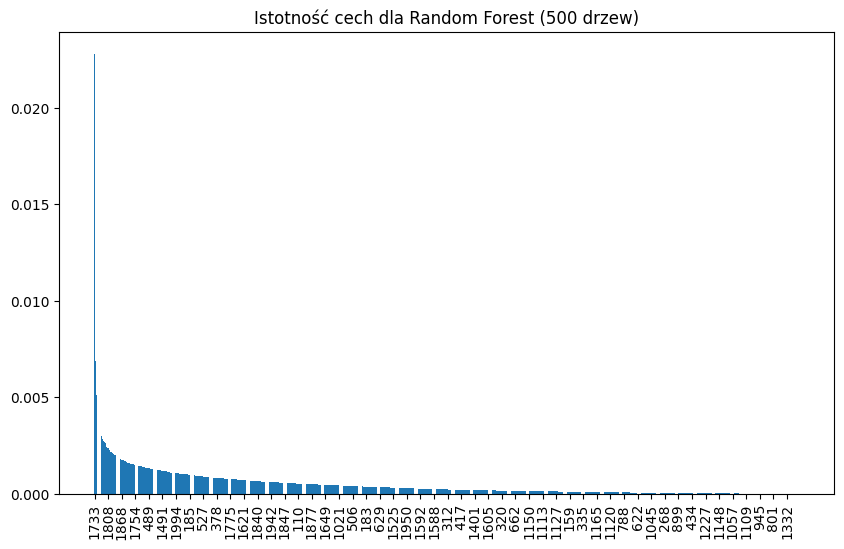

Fold nr 1: błąd OOB dla 1000 drzew = 0.0806
Fold nr 2: błąd OOB dla 1000 drzew = 0.1089
Fold nr 3: błąd OOB dla 1000 drzew = 0.0847
Fold nr 4: błąd OOB dla 1000 drzew = 0.0806
Fold nr 5: błąd OOB dla 1000 drzew = 0.1008
Fold nr 6: błąd OOB dla 1000 drzew = 0.0927
Fold nr 7: błąd OOB dla 1000 drzew = 0.1004
Fold nr 8: błąd OOB dla 1000 drzew = 0.1084
Fold nr 9: błąd OOB dla 1000 drzew = 0.0924
Fold nr 10: błąd OOB dla 1000 drzew = 0.0884
Średni błąd OOB dla 1000 drzew: 0.0938


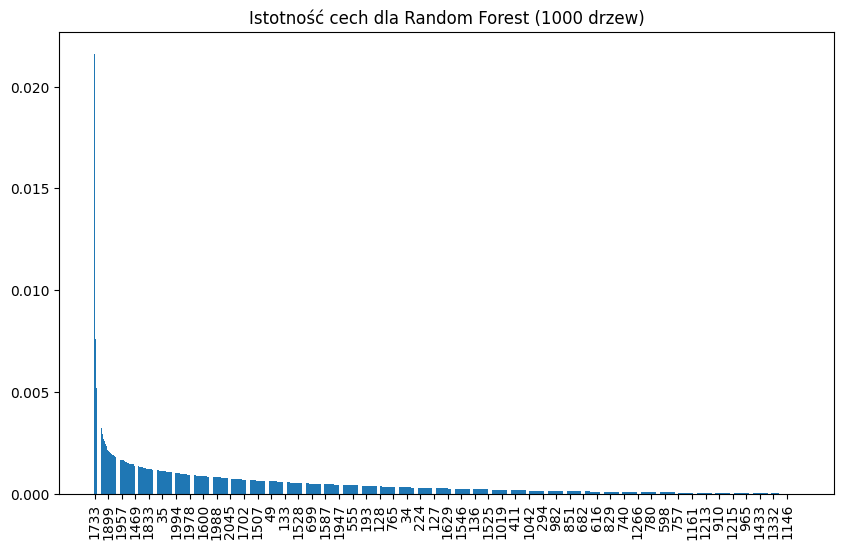

Fold nr 1: błąd OOB dla 5000 drzew = 0.0847
Fold nr 2: błąd OOB dla 5000 drzew = 0.0968
Fold nr 3: błąd OOB dla 5000 drzew = 0.0847
Fold nr 4: błąd OOB dla 5000 drzew = 0.0847
Fold nr 5: błąd OOB dla 5000 drzew = 0.0968
Fold nr 6: błąd OOB dla 5000 drzew = 0.1008
Fold nr 7: błąd OOB dla 5000 drzew = 0.1044
Fold nr 8: błąd OOB dla 5000 drzew = 0.0964
Fold nr 9: błąd OOB dla 5000 drzew = 0.1004
Fold nr 10: błąd OOB dla 5000 drzew = 0.0884
Średni błąd OOB dla 5000 drzew: 0.0938


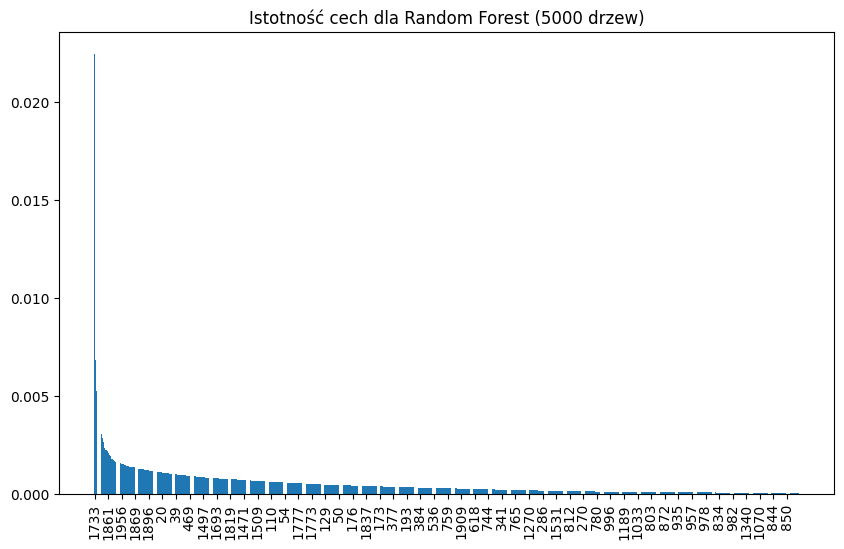

In [19]:
trees = [500, 1000, 5000] #parametry modelu, liczba drzew

for tree in trees:
    model = RandomForestClassifier(n_estimators=tree, random_state=42, oob_score=True)

    oob_errors = []
    fold = 1
    for train_idx, test_idx in cv.split(X_surowica, y_surowica):
        # Podział na zbiór treningowy i testowy dla każdego folda
        X_train, X_test = X_surowica[train_idx], X_surowica[test_idx]
        y_train, y_test = y_surowica[train_idx], y_surowica[test_idx]

        model.fit(X_train, y_train) # Treninowanie modelu Random Forest
        
        # Zbieranie błędu OOB
        oob_errors.append(1 - model.oob_score_)
        print(f"Fold nr {fold}: błąd OOB dla {tree} drzew = {1 - model.oob_score_:.4f}")
        fold += 1

    # Średni błąd OOB dla wszystkich foldów
    avg_oob_error = np.mean(oob_errors)
    print(f"Średni błąd OOB dla {tree} drzew: {avg_oob_error:.4f}")
    
    # Obliczanie istotności cech
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]

    # Generowanie wykresu istotności cech
    plt.figure(figsize=(10,6))
    plt.title(f"Istotność cech dla Random Forest ({tree} drzew)")
    plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
    plt.xticks(range(0, len(feature_importances), 40), indices[::40], rotation=90)  # Wyświetli co 40. etykietę
    plt.show()

    

Selekcja cech  - na podstawie istotności cech wybieramy te najbardziej istotne (10%, 25%, 50%)

In [20]:
# Wybieranie procentu najbardziej istotnych cech
n_features_10 = int(0.1 * len(feature_importances))
n_features_25 = int(0.25 * len(feature_importances))
n_features_50 = int(0.5 * len(feature_importances))

# Indeksy wybranych cech
selected_features_10 = indices[:n_features_10]
selected_features_25 = indices[:n_features_25]
selected_features_50 = indices[:n_features_50]

print(f"10% najbardziej istotnych cech: {selected_features_10}")
print(f"25% najbardziej istotnych cech: {selected_features_25}")
print(f"50% najbardziej istotnych cech: {selected_features_50}")

10% najbardziej istotnych cech: [1733 1734 1726 1725 1732 1964 1727 1965 1962 1968 1963 1735 1967 1537
 1966 1724 1536 1538 1970 1961 1722 1960 1969 1723 1728 1959 2064 2056
 1539 1535 1868 1740 1719 1541 1741   27 1540 1742 1721 2065 1861 1971
 1720 1467 2061 1717 1958 1736 1900 2063 1860 1718 2066 1738 1897 1957
 1739 1716 1743   28 1901 1862 1898   26 2057  450 1757 1749 1755   24
 1899 1863 1804 1746 1466 1484 1808 1744 1711 1575 1956 1486 1715 1834
 2055 1790 1714   29 1731  448 2014 1791 1747   17 2059 1803 1867 1729
  452  445  457 1859 1751  458 1771 1801   21 1792 1748    1 1737 1972
 2069  483 1542   10   40 2062 1485 2060 1869 1468 2072 1932 1805   22
  444  460    6  455 1745 1750  451   16 1817 1807 2071  470 1797  459
 1710 2073   19 1708   23 1692 1756 1794 1576  472   25  447  446    5
  486   11 1753 1931 1875 1754 1896 1470 1713  453 1798   30    3 2015
  503    4 2013  443    9 2070 2067  497 1815 1800 1707 1572 1577  480
  476 1816  484 1796  501  478  456  499 1806

ad 3. Klasyfikacja za pomocą modelu K najbliższych sąsiadów całego zbioru treningowego, oraz zbioru wybranych cech

In [21]:
# Klasyfikator kNN
knn = KNeighborsClassifier(n_neighbors=5)

# Wyniki dla pełnego zbioru cech
accuracies_full = []
accuracies_10 = []
accuracies_25 = []
accuracies_50 = []

for train_idx, test_idx in cv.split(X_surowica, y_surowica):
    X_train, X_test = X_surowica[train_idx], X_surowica[test_idx]
    y_train, y_test = y_surowica[train_idx], y_surowica[test_idx]

    # Pełny zbiór cech
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies_full.append(accuracy_score(y_test, y_pred))
    
    # 10% cech
    knn.fit(X_train[:, selected_features_10], y_train)
    y_pred_10 = knn.predict(X_test[:, selected_features_10])
    accuracies_10.append(accuracy_score(y_test, y_pred_10))
    
    # 25% cech
    knn.fit(X_train[:, selected_features_25], y_train)
    y_pred_25 = knn.predict(X_test[:, selected_features_25])
    accuracies_25.append(accuracy_score(y_test, y_pred_25))
    
    # 50% cech
    knn.fit(X_train[:, selected_features_50], y_train)
    y_pred_50 = knn.predict(X_test[:, selected_features_50])
    accuracies_50.append(accuracy_score(y_test, y_pred_50))

# Średnia dokładność dla różnych zbiorów cech
print(f"Średnia dokładność dla pełnego zbioru cech: {np.mean(accuracies_full):.4f}")
print(f"Średnia dokładność dla 10% cech: {np.mean(accuracies_10):.4f}")
print(f"Średnia dokładność dla 25% cech: {np.mean(accuracies_25):.4f}")
print(f"Średnia dokładność dla 50% cech: {np.mean(accuracies_50):.4f}")


Średnia dokładność dla pełnego zbioru cech: 0.8446
Średnia dokładność dla 10% cech: 0.8734
Średnia dokładność dla 25% cech: 0.8697
Średnia dokładność dla 50% cech: 0.8769


ad 4. Porównanie wyników

Na podstawie przedstawionych wyników średniej dokładności dla całego zbioru danych, oraz dla konkretnych grup cech, można stwierdzić, że zwiększenie ilości cech nie wpływa w tym przypadku zbytnio na zwiększenie dokładności. W celu zwiększenia szybkości trenowania modelu, można ograniczyć ilość cech do 10%.

In [22]:
print("Wybrane cechy wystarczające do osiągnięcia wysokiej dokładności: ")
print(selected_features_10)

Wybrane cechy wystarczające do osiągnięcia wysokiej dokładności: 
[1733 1734 1726 1725 1732 1964 1727 1965 1962 1968 1963 1735 1967 1537
 1966 1724 1536 1538 1970 1961 1722 1960 1969 1723 1728 1959 2064 2056
 1539 1535 1868 1740 1719 1541 1741   27 1540 1742 1721 2065 1861 1971
 1720 1467 2061 1717 1958 1736 1900 2063 1860 1718 2066 1738 1897 1957
 1739 1716 1743   28 1901 1862 1898   26 2057  450 1757 1749 1755   24
 1899 1863 1804 1746 1466 1484 1808 1744 1711 1575 1956 1486 1715 1834
 2055 1790 1714   29 1731  448 2014 1791 1747   17 2059 1803 1867 1729
  452  445  457 1859 1751  458 1771 1801   21 1792 1748    1 1737 1972
 2069  483 1542   10   40 2062 1485 2060 1869 1468 2072 1932 1805   22
  444  460    6  455 1745 1750  451   16 1817 1807 2071  470 1797  459
 1710 2073   19 1708   23 1692 1756 1794 1576  472   25  447  446    5
  486   11 1753 1931 1875 1754 1896 1470 1713  453 1798   30    3 2015
  503    4 2013  443    9 2070 2067  497 1815 1800 1707 1572 1577  480
  476 1816 

# Dataset3 - próbki tkanki

ad 2. Selekcja cech za pomocą modelu Random Forest

Fold nr 1: błąd OOB dla 500 drzew = 0.0035
Fold nr 2: błąd OOB dla 500 drzew = 0.0000
Fold nr 3: błąd OOB dla 500 drzew = 0.0035
Fold nr 4: błąd OOB dla 500 drzew = 0.0035
Fold nr 5: błąd OOB dla 500 drzew = 0.0035
Fold nr 6: błąd OOB dla 500 drzew = 0.0035
Fold nr 7: błąd OOB dla 500 drzew = 0.0035
Fold nr 8: błąd OOB dla 500 drzew = 0.0035
Fold nr 9: błąd OOB dla 500 drzew = 0.0035
Fold nr 10: błąd OOB dla 500 drzew = 0.0035
Średni błąd OOB dla 500 drzew: 0.0032


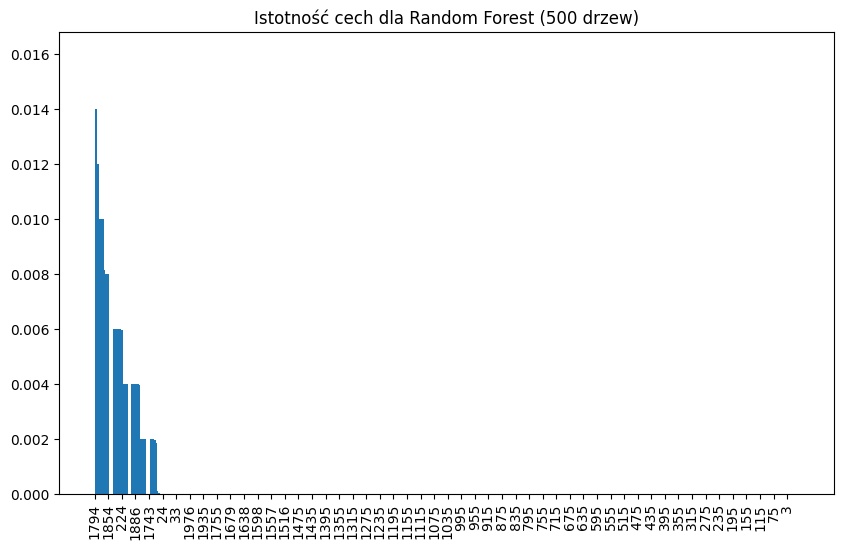

Fold nr 1: błąd OOB dla 1000 drzew = 0.0035
Fold nr 2: błąd OOB dla 1000 drzew = 0.0000
Fold nr 3: błąd OOB dla 1000 drzew = 0.0035
Fold nr 4: błąd OOB dla 1000 drzew = 0.0035
Fold nr 5: błąd OOB dla 1000 drzew = 0.0035
Fold nr 6: błąd OOB dla 1000 drzew = 0.0035
Fold nr 7: błąd OOB dla 1000 drzew = 0.0035
Fold nr 8: błąd OOB dla 1000 drzew = 0.0035
Fold nr 9: błąd OOB dla 1000 drzew = 0.0035
Fold nr 10: błąd OOB dla 1000 drzew = 0.0035
Średni błąd OOB dla 1000 drzew: 0.0032


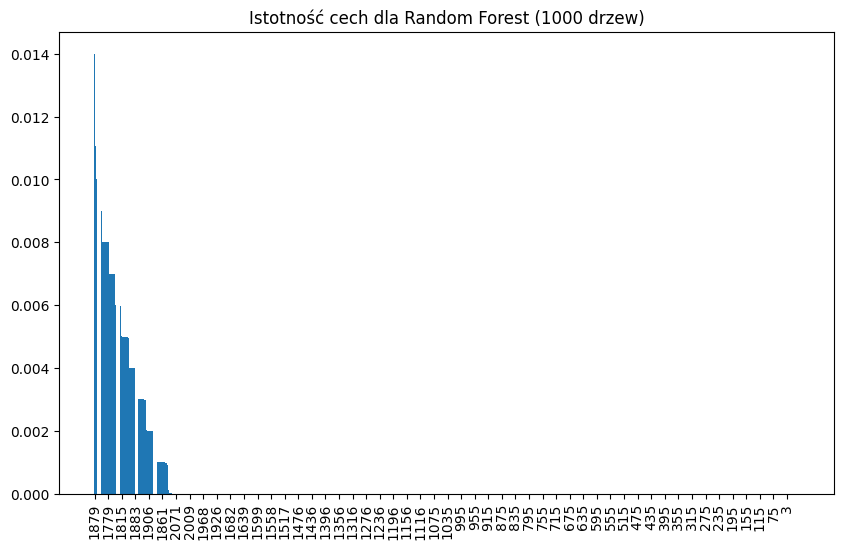

Fold nr 1: błąd OOB dla 5000 drzew = 0.0035
Fold nr 2: błąd OOB dla 5000 drzew = 0.0000
Fold nr 3: błąd OOB dla 5000 drzew = 0.0035
Fold nr 4: błąd OOB dla 5000 drzew = 0.0035
Fold nr 5: błąd OOB dla 5000 drzew = 0.0035
Fold nr 6: błąd OOB dla 5000 drzew = 0.0035
Fold nr 7: błąd OOB dla 5000 drzew = 0.0035
Fold nr 8: błąd OOB dla 5000 drzew = 0.0035
Fold nr 9: błąd OOB dla 5000 drzew = 0.0035
Fold nr 10: błąd OOB dla 5000 drzew = 0.0035
Średni błąd OOB dla 5000 drzew: 0.0032


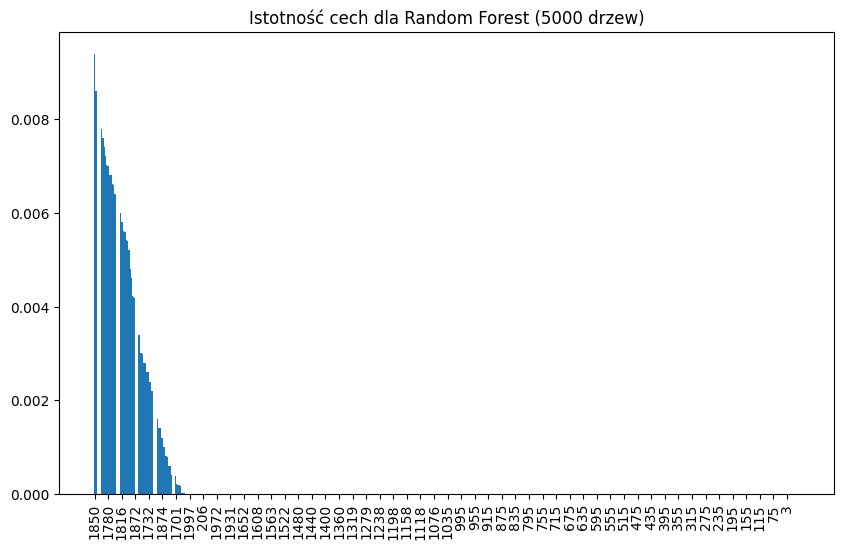

In [27]:
trees = [500, 1000, 5000] #parametry modelu, liczba drzew

for tree in trees:
    model = RandomForestClassifier(n_estimators=tree, random_state=42, oob_score=True)

    oob_errors = []
    fold = 1
    for train_idx, test_idx in cv.split(X_tkanka, y_tkanka):
        # Podział na zbiór treningowy i testowy dla każdego folda
        X_train, X_test = X_tkanka[train_idx], X_tkanka[test_idx]
        y_train, y_test = y_tkanka[train_idx], y_tkanka[test_idx]

        model.fit(X_train, y_train) # Treninowanie modelu Random Forest
        
        # Zbieranie błędu OOB
        oob_errors.append(1 - model.oob_score_)
        print(f"Fold nr {fold}: błąd OOB dla {tree} drzew = {1 - model.oob_score_:.4f}")
        fold += 1

    # Średni błąd OOB dla wszystkich foldów
    avg_oob_error = np.mean(oob_errors)
    print(f"Średni błąd OOB dla {tree} drzew: {avg_oob_error:.4f}")
    
    # Obliczanie istotności cech
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]

    # Generowanie wykresu istotności cech
    plt.figure(figsize=(10,6))
    plt.title(f"Istotność cech dla Random Forest ({tree} drzew)")
    plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
    plt.xticks(range(0, len(feature_importances), 40), indices[::40], rotation=90)  # Wyświetli co 40. etykietę
    plt.show()

    

Selekcja cech  - na podstawie istotności cech wybieramy te najbardziej istotne (10%, 25%, 50%)

In [28]:
# Wybieranie procentu najbardziej istotnych cech
n_features_10 = int(0.1 * len(feature_importances))
n_features_25 = int(0.25 * len(feature_importances))
n_features_50 = int(0.5 * len(feature_importances))

# Indeksy wybranych cech
selected_features_10 = indices[:n_features_10]
selected_features_25 = indices[:n_features_25]
selected_features_50 = indices[:n_features_50]

print(f"10% najbardziej istotnych cech: {selected_features_10}")
print(f"25% najbardziej istotnych cech: {selected_features_25}")
print(f"50% najbardziej istotnych cech: {selected_features_50}")

10% najbardziej istotnych cech: [1850 1797 1823 1904 1782 1806 1844 1880 1840 1803 1805 1879 1882 1869
 1848 1857 1852 1905 1778 1802 1807 1849 1817 1794 1828 1738 1838 1799
 1796 1776 1878 1839 1798 1737 1893 1825 1818 1832 1922 1736 1780 1854
 1829 1784 1791 1847 1804 1845 1923 1814 1822 1770 1785 1867 1781 1810
 1773 1855 1793 1881 1833 1783 1777 1842 1831 1811 1865 1836 1815 1813
 1739 1812 1820 1808 1768 1871 1827 1835 1769 1824 1816 1846 1891 1826
 1789 1772 1809 1800 1801 1775 1853 1870 1786 1834 1830 1788 1883 1924
 1890 1787 1771 1858 1795 1779 1856 1774 1792 1837 1903 1819 1866 1851
 1741 1868 1892 1877 1752 1759 1762 1790 1872 1821 1740 1843 1841 1754
 1751 1742 1761 1918 1731 1750 1748 1753 1746 1912 1730 1745 1760 1906
 1894 1735 1749 1767 1719 1747 1921 1889 1911 1888 1766 1887  223 1884
 1765 1728 1764 1755 1885 1910 1732 1919 1917 1756 1733 1734 1913 1743
 1716 1722 1925 1873 1727 1744 1763 1914 1757  224 1720 1725 1711 1886
 1758 1715 1724 1861 1718 1714 1895 1726 1729

ad 3. Klasyfikacja za pomocą modelu K najbliższych sąsiadów całego zbioru treningowego, oraz zbioru wybranych cech

In [29]:
# Klasyfikator kNN
knn = KNeighborsClassifier(n_neighbors=5)

# Wyniki dla pełnego zbioru cech
accuracies_full = []
accuracies_10 = []
accuracies_25 = []
accuracies_50 = []

for train_idx, test_idx in cv.split(X_tkanka, y_tkanka):
    X_train, X_test = X_tkanka[train_idx], X_tkanka[test_idx]
    y_train, y_test = y_tkanka[train_idx], y_tkanka[test_idx]

    # Pełny zbiór cech
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies_full.append(accuracy_score(y_test, y_pred))
    
    # 10% cech
    knn.fit(X_train[:, selected_features_10], y_train)
    y_pred_10 = knn.predict(X_test[:, selected_features_10])
    accuracies_10.append(accuracy_score(y_test, y_pred_10))
    
    # 25% cech
    knn.fit(X_train[:, selected_features_25], y_train)
    y_pred_25 = knn.predict(X_test[:, selected_features_25])
    accuracies_25.append(accuracy_score(y_test, y_pred_25))
    
    # 50% cech
    knn.fit(X_train[:, selected_features_50], y_train)
    y_pred_50 = knn.predict(X_test[:, selected_features_50])
    accuracies_50.append(accuracy_score(y_test, y_pred_50))

# Średnia dokładność dla różnych zbiorów cech
print(f"Średnia dokładność dla pełnego zbioru cech: {np.mean(accuracies_full):.4f}")
print(f"Średnia dokładność dla 10% cech: {np.mean(accuracies_10):.4f}")
print(f"Średnia dokładność dla 25% cech: {np.mean(accuracies_25):.4f}")
print(f"Średnia dokładność dla 50% cech: {np.mean(accuracies_50):.4f}")


Średnia dokładność dla pełnego zbioru cech: 1.0000
Średnia dokładność dla 10% cech: 0.9969
Średnia dokładność dla 25% cech: 1.0000
Średnia dokładność dla 50% cech: 1.0000


ad 4. Porównanie wyników

Na podstawie przedstawionych wyników średniej dokładności dla całego zbioru danych, oraz zbiorów wyselekcjonowanych cech, można stwierdzić, najlepsze wyniki uzyskujemy dla trenowania minimum 25% cech.

In [26]:
print("Wybrane cechy wystarczające do osiągnięcia wysokiej dokładności: ")
print(selected_features_25)

Wybrane cechy wystarczające do osiągnięcia wysokiej dokładności: 
[1850 1840 1882 1818 1805 1844 1803 1879 1880 1807 1806 1849 1814 1869
 1857 1838 1797 1848 1852 1828 1776 1782 1778 1804 1854 1768 1798 1791
 1829 1867 1799 1832 1878 1796 1823 1817 1802 1770 1784 1739 1820 1893
 1783 1785 1736 1865 1905 1822 1811 1835 1773 1842 1769 1834 1847 1794
 1813 1833 1812 1871 1845 1839 1855 1737 1777 1824 1825 1738 1826 1830
 1793 1781 1831 1881 1780 1853 1800 1809 1810 1858 1787 1815 1883 1891
 1827 1772 1836 1789 1816 1774 1786 1892 1801 1872 1788 1846 1856 1792
 1779 1866 1870 1775 1890 1851 1819 1808 1795 1740 1837 1790 1771 1735
 1753 1877 1841 1741 1762 1868 1821 1765 1756 1754 1904 1922 1906 1843
 1730 1750 1745 1749 1752 1746 1924 1903 1888 1764 1917 1759 1734 1748
 1923 1767 1758 1720 1731 1747 1744 1751 1719 1763 1894 1887 1725 1742
 1713 1886 1733 1757 1732 1714 1755 1884 1921 1911 1889 1885 1760 1729
 1761 1873 1712 1766 1920 1918 1727 1919 1726 1722 1724 1723 1716 1718
 1861 1717 